# Research Report on Adam: A Method for Stochastic Optimization

## Authors: Tom Dupuis & Clément Bonnet

---

In [1]:
import matplotlib
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
from sklearn.utils import check_random_state
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn import model_selection
from tqdm import trange, tqdm

# Uncomment to better plot in the notebook (not exporting)
%matplotlib inline
# Uncomment the following lines to export plots to Latex
# matplotlib.use("pgf")
# matplotlib.rcParams.update({
#     "pgf.texsystem": "pdflatex",
#     'font.family': 'serif',
#     'text.usetex': True,
#     'pgf.rcfonts': False,
# })

## Logistic Regression

Logistic regression is one of the simplest ways to deal with a classification problem. Instead of fitting a line as it is done in linear regression, logistic regression models the probability that the outcome is 1 given the value of the predictor. In order to do this we need a function that transforms our predictor variable to a value between 0 and 1. Lots of functions can do that, but the logistic function is the most common choice:

$$\sigma(z) = \frac{1}{1+e^{-z}}.$$

To predict the class of our observations we have to minimize the corresponding logistic loss function to which we add a Ridge regularization term ($\mathrm{L}^2$) as we are in a high-dimensional context.

$$L(\textbf{w}) = \sum_{i=1}^n log(1+\exp(-y_i\textbf{w}^Tx_i))+\frac{\lambda}{2} \| \textbf{w} \|_2^2,$$

where $x_i$ is the vector of features for the observation $i$ and $y_i \in \{-1, 1\}$ is the class label.  


In [2]:
class LogisticRegression():

    def __init__(self, optimizer = 'Adam', lr=1e-3, gamma=0.9, beta=0.999, max_iter=100, lambda_=100,
                batch_size=1, eps=1e-10, debias=1, start=None, progress_bar=False):
        self.coef_ = None
        self.lambda_ = lambda_
        self.lr_ = lr
        self.batch_size_ = batch_size
        self.coef_history_ = []
        self.f_history_ = []
        self.gamma_ = gamma
        self.beta_ = beta
        self.eps_ = eps
        self.debias_ = debias
        self.iter_ = max_iter
        self.start_ = start
        self.progress_bar_ = progress_bar
        self.optimizer = optimizer
        
        
    def fit(self, X, y):
     
        n, p =  X.shape
        X_aug = np.ones((n, p + 1))
        X_aug[:, 1:] = X
        
        # Initialize: theta_init, grad_init, m_init, s_init
        theta = self.start_
        if theta is None:
            theta = np.random.normal(size=(p+1,1))
        grad = np.zeros((p+1,1))
        m = np.zeros((p+1,1))
        s = np.zeros((p+1,1))
        
        def logistic(z):
            # logistic function
            return(1 / (1 + np.exp(-z)))
        
        def loss(theta):
            return(np.sum(np.log(1+np.exp(-(X_aug*y)@theta))) + self.lambda_/2*np.linalg.norm(theta))**2
        
        def compute_grad(theta, batch_indices):
            g = self.lambda_ * theta
            for i in batch_indices:
                w = y[i] * (logistic(y[i]*X_aug[i,:]@theta) - 1) * X_aug[i,:].T
                g = g + w[:,np.newaxis]
            return(g)
        
        self.f_history_.append(loss(theta))
        
        # Iteration: compute theta_t, grad_t, m_t, s_t
        for t in trange(1, self.iter_ + 1, disable=not(self.progress_bar_)):
            
            batch = list(np.random.choice(n, size=self.batch_size_, replace=False))
            self.coef_history_ += batch
            
            grad = compute_grad(theta, batch)
            if self.optimizer == 'Adam':
                if self.debias_:
                    m = self.beta_ * m + (1-self.beta_) * grad / (1 - np.power(self.beta_,t))
                    s = self.gamma_ * s + (1-self.gamma_) * np.power(grad,2) / (1 - np.power(self.gamma_,t))
                else:
                    m = self.beta_ * m + (1-self.beta_) * grad
                    s = self.gamma_ * s + (1-self.gamma_) * np.power(grad,2)
                    
            elif self.optimizer == 'Adam (no debiasing)':
                m = self.beta_ * m + (1-self.beta_) * grad
                s = self.gamma_ * s + (1-self.gamma_) * np.power(grad,2)
            
            elif self.optimizer == 'AdaGrad':
                m = grad
                s = s + np.power(grad,2)
                
            elif self.optimizer == 'RMSProp':
                m = grad
                s = self.gamma_ * s + (1-self.gamma_) * np.power(grad,2)
                
            elif self.optimizer == 'Momentum':
                m = self.beta_ * m + (1-self.beta_) * grad
                s = np.ones((p+1,1))
                
            elif self.optimizer == 'Vanilla':
                m = grad
                s = np.ones((p+1,1))
                
            theta = theta - self.lr_*m / (np.sqrt(s)+self.eps_)
            
            self.f_history_.append(loss(theta))    
        
        self.coef_ = theta
            
        
    def predict(self, X):

        def logistic(z):
            return(1 / (1 + np.exp(-z)))
        
        n, p =  X.shape
        X_aug = np.ones((n, p + 1))
        X_aug[:, 1:] = X
        
        y_pred = np.round(logistic(X_aug @ self.coef_))
        
        return(y_pred)

### Data preprocessing

In [3]:
data_train = pd.read_csv("w8a.csv", sep=";", header=None)
data_test = pd.read_csv("w8a_t.csv", sep=";", header=None)

X_train = data_train.iloc[:, :-1].to_numpy()
y_train = data_train.iloc[:, -1].to_numpy()
X_test = data_test.iloc[:, :-1].to_numpy()
y_test = data_test.iloc[:, -1].to_numpy()
y_test[y_test == -1] = 0
y_test = y_test[:,np.newaxis]

In [4]:
eigenvalues = np.linalg.eigh(X_train.T @ X_train)
kappa = np.abs(np.max(eigenvalues[0])/np.min(eigenvalues[0]))
print(kappa)

5.4075082389815224e+16


$\kappa$ is high and thus the problem is poorly conditioned for AdaGrad.

In [5]:
np.random.seed(0)
p = X_train.shape[1]
start_ = np.random.normal(size=(p+1,1))

## Analysis of the parameters

In the following simulations, we study the evolution of parameters such as the learning rate $l_r$, the batch size, $\beta$, $\gamma$ and the debiasing.

In [6]:
# Set baseline parameters

eta = 1e-2             # the learning rate
gam = 0.9              # gamma
bet = 0.1              # beta
max_iter = 100
lambda_ = 10           # lambda_
batch = 25             # batch size
epsilon = 1e-10
deb = 0                # debias = 0 if FALSE and 1 if TRUE
start = start_

rep = 4

$\texttt{rep}$ is the number of simulations done for each variation of a parameter's value.
For all simulations, we plot the evaluations of the loss function at each step of the stochastic logistic regression.

### Analysis of the learning rate

100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [02:21<00:00, 35.30s/it]


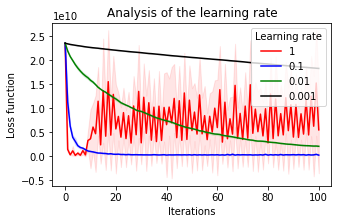

In [7]:
lr_list = [1, 0.1, 0.01, 0.001]
colors = ['red', 'blue', 'green', 'black']
rep = 4
max_iter = 100

np.random.seed(0)
scores_mean = np.empty(len(lr_list))
scores_std = np.empty(len(lr_list))
curves_mean = np.empty((len(lr_list), max_iter+1))
curves_std = np.empty((len(lr_list), max_iter+1))
scores = np.empty(rep)
curves = np.empty((rep, max_iter+1))
for i, lr in enumerate(tqdm((lr_list), disable=False)):
    for j in range(rep):
        model = LogisticRegression(
            lr=lr, gamma=gam, beta=bet, max_iter=max_iter, 
            lambda_=lambda_, batch_size=batch, eps=epsilon, debias=deb, start=start)
        model.fit(X_train, y_train[:,np.newaxis])
        y_pred = model.predict(X_test)
        scores[j] = accuracy_score(y_test, y_pred)
        curves[j] = np.array(model.f_history_)
    scores_mean[i] = scores.mean()
    scores_std[i] = scores.std()
    curves_mean[i] = curves.mean(axis=0)
    curves_std[i] = curves.std(axis=0)

plt.figure(figsize = (5,3))
plt.title('Analysis of the learning rate')
for i, lr in enumerate(lr_list):
    plt.plot(curves_mean[i], "-", color=colors[i],
             label="{}".format(lr))
    plt.fill_between(range(len(curves_mean[i])),
                     curves_mean[i]-curves_std[i], curves_mean[i]+curves_std[i],
                     alpha=0.1, color=colors[i])
plt.legend(title = "Learning rate")
plt.xlabel("Iterations")
plt.ylabel("Loss function")
plt.show()     # uncomment to show plot
# plt.savefig('plots/learning_rate.pgf')      # uncomment to export plot to LaTeX

When the learning rate si too high ($lr\geq 0.1$), the function $t\mapsto L(\theta_t)$ is not monotonic. The final $\theta$ could be less optimal than the initial vector $\theta_0$. In this case, there is no convergence of the algorithm. On the other hand, if lr is too small ($lr\leq 0.001$), the convergence will be very slow and will need a high number of iteration to reach the same accuracy.

### Analysis of the batch size.

100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [02:23<00:00, 35.81s/it]


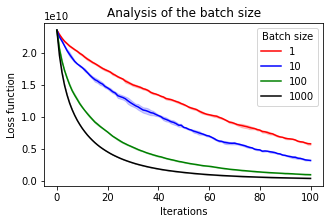

In [8]:
bs_list = [1, 10, 100, 1000]
colors = ['red', 'blue', 'green', 'black']
rep = 4
max_iter = 100

np.random.seed(0)
scores_mean = np.empty(len(bs_list))
scores_std = np.empty(len(bs_list))
curves_mean = np.empty((len(bs_list), max_iter+1))
curves_std = np.empty((len(bs_list), max_iter+1))
scores = np.empty(rep)
curves = np.empty((rep, max_iter+1))
for i, bs in enumerate(tqdm((bs_list), disable=False)):
    for j in range(rep):
        model = LogisticRegression(
            lr=eta, gamma=gam, beta=bet, max_iter=max_iter, 
            lambda_=lambda_, batch_size=bs, eps=epsilon, debias=deb, start=start)
        model.fit(X_train, y_train[:,np.newaxis])
        y_pred = model.predict(X_test)
        scores[j] = accuracy_score(y_test, y_pred)
        curves[j] = np.array(model.f_history_)
    scores_mean[i] = scores.mean()
    scores_std[i] = scores.std()
    curves_mean[i] = curves.mean(axis=0)
    curves_std[i] = curves.std(axis=0)   
    
plt.figure(figsize = (5,3))
plt.title('Analysis of the batch size')
for i, bs in enumerate(bs_list):
    plt.plot(curves_mean[i], "-", color=colors[i],
             label="{}".format(bs))
    plt.fill_between(range(len(curves_mean[i])), curves_mean[i]-curves_std[i], curves_mean[i]+curves_std[i], alpha=0.2, color=colors[i])
plt.legend(title = "Batch size")
plt.xlabel("Iterations")
plt.ylabel("Loss function")
plt.show()     # uncomment to show plot
# plt.savefig('plots/batch_size.pgf')      # uncomment to export plot to LaTeX

As expected, the stochastic algorithm is more efficient when the batch size increases. However one cannot optimize the performance of the algorithm only with the size of the batch: sizes 100 and 1000 have similar outcomes and convergence speed.

We can note that in the case of the stochastic gradient descent (batch size = 1), even though it works impressively considering the little amount of data used to compute the gradient, it is far from being efficient.

### Analysis of $\beta_1$ .

100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [02:49<00:00, 33.94s/it]


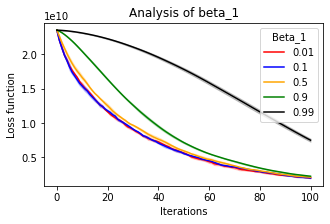

In [9]:
beta_list = [0.01, 0.1, 0.5, 0.9, 0.99]
colors = ['red', 'blue', 'orange', 'green', 'black']
rep = 4
max_iter = 100

np.random.seed(0)
scores_mean = np.empty(len(beta_list))
scores_std = np.empty(len(beta_list))
curves_mean = np.empty((len(beta_list), max_iter+1))
curves_std = np.empty((len(beta_list), max_iter+1))
scores = np.empty(rep)
curves = np.empty((rep, max_iter+1))
for i, beta in enumerate(tqdm((beta_list), disable=False)):
    for j in range(rep):
        model = LogisticRegression(
            lr=eta, gamma=gam, beta=beta, max_iter=max_iter, 
            lambda_=lambda_, batch_size=batch, eps=epsilon, debias=deb, start=start)
        model.fit(X_train, y_train[:,np.newaxis])
        y_pred = model.predict(X_test)
        scores[j] = accuracy_score(y_test, y_pred)
        curves[j] = np.array(model.f_history_)
    scores_mean[i] = scores.mean()
    scores_std[i] = scores.std()
    curves_mean[i] = curves.mean(axis=0)
    curves_std[i] = curves.std(axis=0)

    
    
plt.figure(figsize = (5,3))
plt.title('Analysis of beta_1')
for i, beta in enumerate(beta_list):
    plt.plot(curves_mean[i], "-", color=colors[i],
             label="{}".format(beta))
    plt.fill_between(range(len(curves_mean[i])), curves_mean[i]-curves_std[i], curves_mean[i]+curves_std[i], alpha=0.2, color=colors[i])
plt.legend(title = "Beta_1")
plt.xlabel("Iterations")
plt.ylabel("Loss function")
plt.show()     # uncomment to show plot
# plt.savefig('plots/beta_1.pgf')      # uncomment to export plot to LaTeX

$\beta$ is the parameter of position. Set $\beta=0$ to transform the algorithm into the Vanilla/Adagrad algorithm. Set $\beta$ close to 1 to take into account more the past than the gradient calculated at time $t$. Convergence seems to be slower during the first iterations when $\beta$ is close to $1$: there is a greater inertia of the algorithm, so it takes some time to reorient its gradient into the correct direction towards the minimum. Although this can be a problem in this setting, it actually becomes valuable in a highly non-convex setting.

### Analysis of $\beta_2$.

100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [02:50<00:00, 34.02s/it]


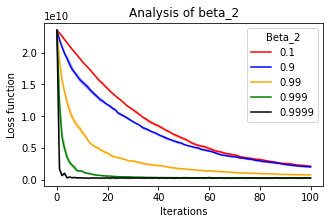

In [10]:
gamma_list = [0.1, 0.9, 0.99, 0.999, 0.9999]
colors = ['red', 'blue', 'orange', 'green', 'black']
rep = 4
max_iter = 100

np.random.seed(0)
scores_mean = np.empty(len(gamma_list))
scores_std = np.empty(len(gamma_list))
curves_mean = np.empty((len(gamma_list), max_iter+1))
curves_std = np.empty((len(gamma_list), max_iter+1))
scores = np.empty(rep)
curves = np.empty((rep, max_iter+1))
for i, gamma in enumerate(tqdm((gamma_list), disable=False)):
    for j in range(rep):
        model = LogisticRegression(
            lr=eta, gamma=gamma, beta=bet, max_iter=max_iter, 
            lambda_=lambda_, batch_size=batch, eps=epsilon, debias=deb, start=start)
        model.fit(X_train, y_train[:,np.newaxis])
        y_pred = model.predict(X_test)
        scores[j] = accuracy_score(y_test, y_pred)
        curves[j] = np.array(model.f_history_)
    scores_mean[i] = scores.mean()
    scores_std[i] = scores.std()
    curves_mean[i] = curves.mean(axis=0)
    curves_std[i] = curves.std(axis=0)

plt.figure(figsize = (5,3))
plt.title('Analysis of beta_2')
for i, gamma in enumerate(gamma_list):
    plt.plot(curves_mean[i], "-", color=colors[i],
             label="{}".format(gamma))
    plt.fill_between(range(len(curves_mean[i])), curves_mean[i]-curves_std[i], curves_mean[i]+curves_std[i], alpha=0.2, color=colors[i])
plt.legend(title = "Beta_2")
plt.xlabel("Iterations")
plt.ylabel("Loss function")
plt.show()     # uncomment to show plot
# plt.savefig('plots/beta_2.pgf')      # uncomment to export plot to LaTeX

$\gamma$ is the parameter of speed (of convergence). Set $\gamma=1$ to transform the algorithm into the Vanilla algorithm. Set $\gamma\to0$ to take into account only the direction of the gradient and not its norm. The convergence is indeed faster when when $\gamma$ is close to $1$.

### Debiasing or not ?

100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [01:10<00:00, 35.24s/it]


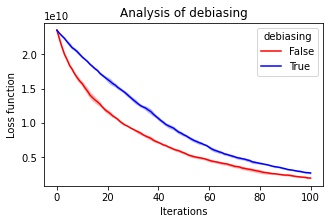

In [11]:
debias_list = [False, True]
colors = ['red', 'blue']
rep = 4
max_iter = 100

np.random.seed(10)
scores_mean = np.empty(len(debias_list))
scores_std = np.empty(len(debias_list))
curves_mean = np.empty((len(debias_list), max_iter+1))
curves_std = np.empty((len(debias_list), max_iter+1))
scores = np.empty(rep)
curves = np.empty((rep, max_iter+1))
for i, debias in enumerate(tqdm((debias_list), disable=False)):
    for j in range(rep):
        model = LogisticRegression(
            lr=eta, gamma=gam, beta=bet, max_iter=max_iter, 
            lambda_=lambda_, batch_size=batch, eps=epsilon, debias=debias, start=start)
        model.fit(X_train, y_train[:,np.newaxis])
        y_pred = model.predict(X_test)
        scores[j] = accuracy_score(y_test, y_pred)
        curves[j] = np.array(model.f_history_)
    scores_mean[i] = scores.mean()
    scores_std[i] = scores.std()
    curves_mean[i] = curves.mean(axis=0)
    curves_std[i] = curves.std(axis=0)

plt.figure(figsize = (5,3))
plt.title('Analysis of debiasing')
for i, debias in enumerate(debias_list):
    plt.plot(curves_mean[i], "-", color=colors[i],
             label="{}".format(["False", "True"][debias]))
    plt.fill_between(range(len(curves_mean[i])), curves_mean[i]-curves_std[i], curves_mean[i]+curves_std[i], alpha=0.2, color=colors[i])
plt.legend(title = "debiasing")
plt.xlabel("Iterations")
plt.ylabel("Loss function")
plt.show()     # uncomment to show plot
# plt.savefig('plots/debiasing.pgf')      # uncomment to export plot to LaTeX

The debiasing parameter introduces a factor in front of the terms of the gradient to remove the bias of the algorithm. However, it seems in this case, the algorithm converges slower than without the debiasing term. An explanation is that the algorithm is more cautious when having a debiasing term: it may not take the shortest path to a minimum.

### Comparison with other optimizers

In [12]:
# Set baseline parameters

eta = 1e-2             # the learning rate
gam = 0.99             # gamma
bet = 0.1              # beta
max_iter = 100
lambda_ = 10           # lambda_
batch = 25             # batch size
epsilon = 1e-10
deb = 0                # debias = 0 if FALSE and 1 if TRUE
start = start_

rep = 4

100%|████████████████████████████████████████████████████████████████████████████████████| 6/6 [03:27<00:00, 34.58s/it]


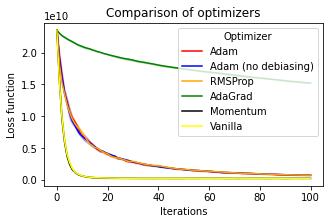

In [13]:
optimizers = ['Adam', 'Adam (no debiasing)', 'RMSProp', 'AdaGrad', 'Momentum', 'Vanilla'] 
colors = ['red', 'blue','orange', 'green', 'black', 'yellow']
rep = 4
max_iter = 100

np.random.seed(0)
scores_mean = np.empty(len(optimizers))
scores_std = np.empty(len(optimizers))
curves_mean = np.empty((len(optimizers), max_iter+1))
curves_std = np.empty((len(optimizers), max_iter+1))
scores = np.empty(rep)
curves = np.empty((rep, max_iter+1))
for i, opt in enumerate(tqdm((optimizers), disable=False)):
    for j in range(rep):
        model = LogisticRegression(optimizer=opt,
            lr=eta, gamma=gam, beta=bet, max_iter=max_iter, 
            lambda_=lambda_, batch_size=batch, eps=epsilon, debias=deb, start=start)
        model.fit(X_train, y_train[:,np.newaxis])
        y_pred = model.predict(X_test)
        scores[j] = accuracy_score(y_test, y_pred)
        curves[j] = np.array(model.f_history_)
    scores_mean[i] = scores.mean()
    scores_std[i] = scores.std()
    curves_mean[i] = curves.mean(axis=0)
    curves_std[i] = curves.std(axis=0)

plt.figure(figsize = (5,3))
plt.title('Comparison of optimizers')
for i, opt in enumerate(optimizers):
    plt.plot(curves_mean[i], "-", color=colors[i],
             label="{}".format(opt))
    plt.fill_between(range(len(curves_mean[i])), curves_mean[i]-curves_std[i], curves_mean[i]+curves_std[i], alpha=0.2, color=colors[i])
plt.legend(title = "Optimizer")
plt.xlabel("Iterations")
plt.ylabel("Loss function")
plt.show()     # uncomment to show plot
# plt.savefig('plots/optimizers.pgf')      # uncomment to export plot to LaTeX